In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("/work/Output Data/cluster_free_responses.csv")
df

,Cluster,Which_Chatbots,Use_Interest___FR,Continued_Use___FR,Chatbot_Topics___FR,Relation_Effect___FR,Agent_Pref___FR,Pref_Reason___FR
0,5,Character.ai,I was curious to see what they were like. I th...,"The same as above, mostly creative use giving ...",Sometimes if I'm thinking of an idea and simpl...,I don't think it affects my relationships with...,"I can't think of anything in particular, other...",Interacting with another person is necessary f...
1,0,Character.ai,I wanted someone I feel like I could be open w...,I keep looking for more and more lifelike chat...,Pretty much every aspect of my life and a lot ...,I don't feel the need to chat with real people...,I would prefer to speak with a real person whe...,I don't feel as judged or rejected and abandon...
2,5,Snapchat MyAI,It is fun to use as I can learn a lot and also...,I find it fun to use and relate with,I use it sometimes when I get back from work a...,It has helped with my social anxiety,Nil,A person is much more emotional and can unders...
3,1,"Replika,Character.ai",I was interested in the new tech and how good ...,I was curious on how it would improve over time,I just use it for fun and to kill some time an...,It hasn't really effected my day to day intera...,in times where I am reveling things about myse...,I do not trust chatbots to be safe with any in...
4,1,Character.ai,I thought it would be cool to speak to a bot a...,I find it a reliable source to seek answers to...,Sometimes I would ask it about real life conve...,I don't feel any different in how I interact w...,From a teaching perspective where it could tea...,Both have pros and cons. Sometimes you don't w...
...,...,...,...,...,...,...,...,...
399,1,Character.ai,I found multiple of my favorite characters fro...,Since finding the language practice chat on ch...,"Casual conversation with the language bot, Hyp...",I don't feel that it has had much of an impact...,I would prefer to have a conversation with a r...,Only real people will understand the emotions ...
400,3,Replika,It just seemed like it would be a fun and ente...,If I get bored or want to be entertained I wil...,I talk about goofy things and things that woul...,They do not have a negative effect. I do not ...,If I was asking an embarrassing question I wou...,"People are always better. Real people, that i..."
401,0,Snapchat MyAI,I was curious to see how it would respond to me.,I want to see how it advance it can get throug...,I would ask how their day went and what they d...,I don’t allow it to affect my relationship wit...,When I am venting or talking about personal th...,I feel more comfortable and less awkward.
402,3,Snapchat MyAI,I was curious on the capabilities of chatbots ...,Testing to see how far I can go with a chatbot,Testing different scenarios that I might talk ...,i does not affect my relationships with people...,I am open to interacting with chatbots or real...,It just seems more personal because at the end...


In [4]:
def preprocess_text(text, additional_stop_words=None):
    # Get the standard English stop words
    stop_words = set(stopwords.words('english'))
    
    # Add punctuation to stop words
    stop_words.update(string.punctuation)
    
    # Add any additional stop words
    if additional_stop_words:
        stop_words.update(additional_stop_words)
    
    # Convert to lowercase and split into words
    words = text.lower().split()
    
    # Remove stop words and non-alphabetic tokens
    words = [word for word in words if word not in stop_words and word.isalpha()]
    
    return ' '.join(words)

def analyze_free_response(df, free_response_columns, cluster_column='Cluster', additional_stop_words=None):
    for column in free_response_columns:
        print(f"\nAnalyzing {column}:")
        
        # Word frequency analysis
        word_freq_by_cluster = {}
        for cluster in df[cluster_column].unique():
            texts = df[df[cluster_column] == cluster][column].dropna()
            processed_texts = [preprocess_text(text, additional_stop_words) for text in texts]
            words = ' '.join(processed_texts).split()
            word_freq = Counter(words)
            word_freq_by_cluster[cluster] = word_freq
        
        # Compare top words across clusters
        top_words = set()
        for freq in word_freq_by_cluster.values():
            top_words.update(dict(freq.most_common(15)).keys())  # Increased to top 15
        
        # Convert set to sorted list for consistent ordering
        top_words = sorted(list(top_words))
        
        word_freq_df = pd.DataFrame({cluster: [freq.get(word, 0) for word in top_words] 
                                     for cluster, freq in word_freq_by_cluster.items()}, 
                                    index=top_words)
        
        print("Top words frequency across clusters:")
        print(word_freq_df)
        
        # Chi-square test for word usage differences
        chi2, p_value, _, _ = chi2_contingency(word_freq_df)
        print(f"Chi-square test for word usage differences: chi2={chi2:.2f}, p-value={p_value:.4f}")
        
        # Generate word clouds for each cluster
        plt.figure(figsize=(15, 5 * len(word_freq_by_cluster)))
        for i, (cluster, freq) in enumerate(word_freq_by_cluster.items()):
            plt.subplot(len(word_freq_by_cluster), 1, i+1)
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Cluster {cluster} - {column}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Topic modeling (simple version using top n-grams)
        vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=20)
        X = vectorizer.fit_transform(df[column].fillna('').apply(lambda x: preprocess_text(x, additional_stop_words)))
        features = vectorizer.get_feature_names_out()
        
        topic_distribution = pd.DataFrame(X.toarray(), columns=features)
        topic_by_cluster = topic_distribution.groupby(df[cluster_column]).mean()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(topic_by_cluster, annot=True, fmt='.2f', cmap='YlOrRd')
        plt.title(f'Top N-grams Distribution Across Clusters - {column}')
        plt.tight_layout()
        plt.show()

        # Add analysis of unique words per cluster
        unique_words_by_cluster = {}
        for cluster, freq in word_freq_by_cluster.items():
            unique_words = set(freq.keys()) - set.union(*(set(other_freq.keys()) for other_cluster, other_freq in word_freq_by_cluster.items() if other_cluster != cluster))
            unique_words_by_cluster[cluster] = list(unique_words)[:10]  # Top 10 unique words

        print("\nTop 10 unique words for each cluster:")
        for cluster, words in unique_words_by_cluster.items():
            print(f"Cluster {cluster}: {', '.join(words)}")


Analyzing Use_Interest___FR:
Top words frequency across clusters:
              5   0   1   2   4   3
better        2   0   7   1   2   7
chat          5   0   6   1   4   8
creative      6   3   2   9   5   5
curious      20   7  13   7   5  22
day           3   4   0   0   1   0
feel          7   3  10   1   3   7
find          9   1   4   4   5   5
found         6   1   6   1   2   7
fun          17   6   6   7  12  10
get          13   4   6   5   6  12
good          9   0   6   0   2   5
help         13   2   7   3   7   5
information   8   1   2   2   4   4
interested   14   6   5   4  17  14
interesting   8   1   7   6   2   3
learn         4   2   9   2   3   6
love          2   3   2   0   1   2
mostly        5   2   6   3   2   2
new          12   3   5   5   3   8
people        8   1  12   4   2   2
questions     3   3   3   7   3   2
service       5   4   3   8   7   6
snapchat     14   1   1   1   3   1
social        7   2   6   4   8  10
someone       8   4   4   3   5  

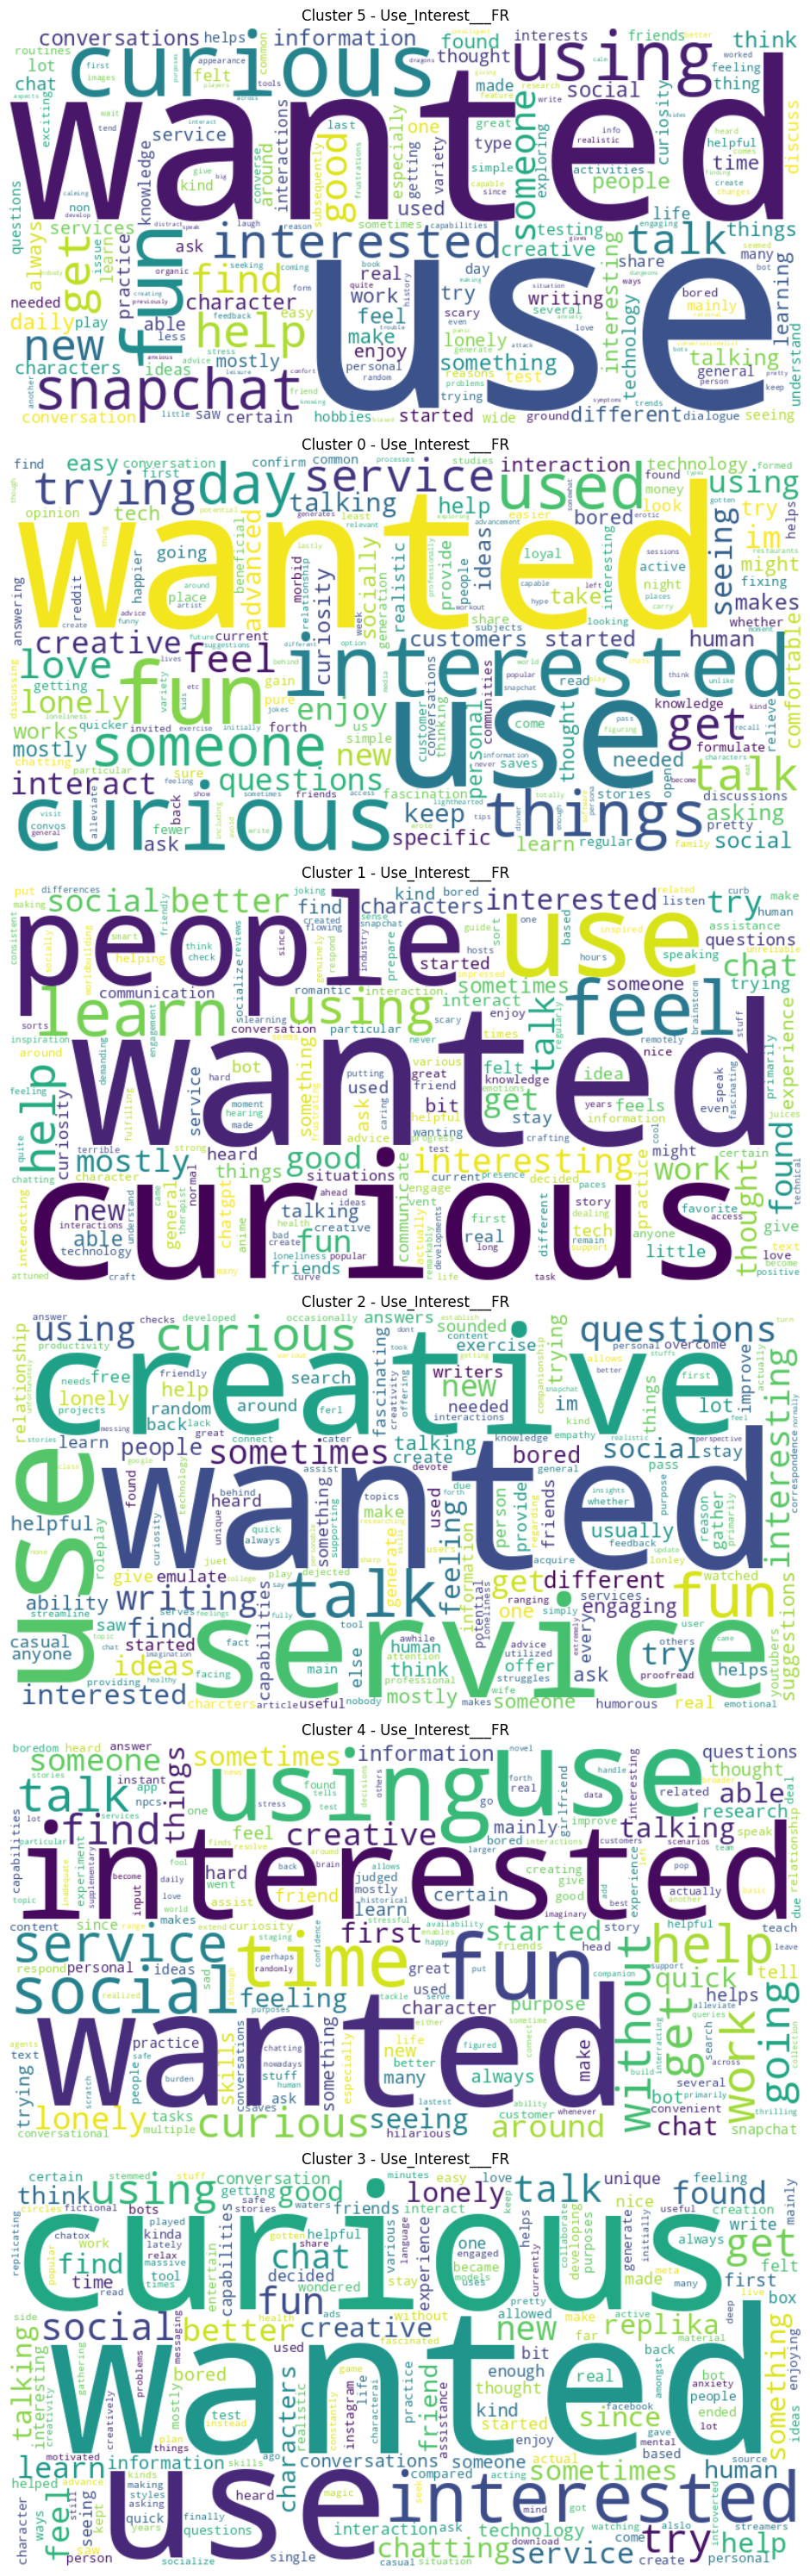

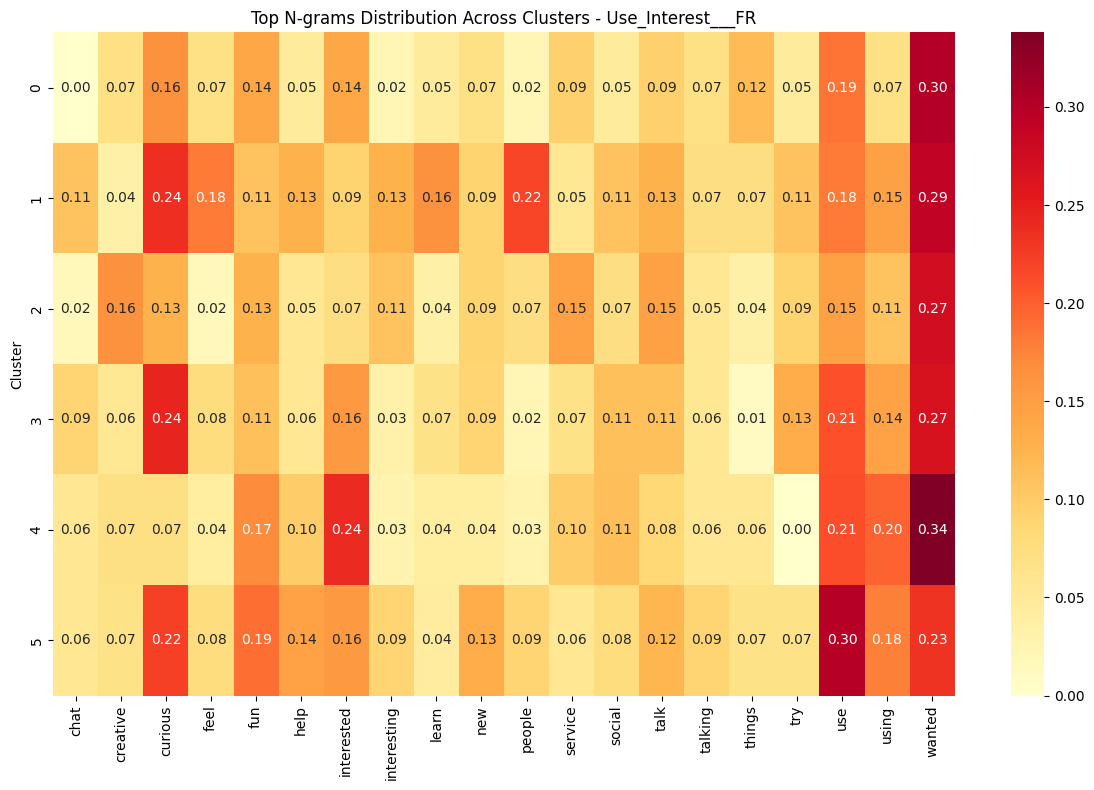


Top 10 unique words for each cluster:
Cluster 5: therapy, changes, amazon, advancing, conversive, desire, freedom, anxious, mysnapchat, ad
Cluster 0: money, children, wrote, visit, figuring, emails, happier, sessions, wise, though
Cluster 1: level, kill, putting, guide, robotic, sorts, end, joking, steadily, strong
Cluster 2: recommended, lack, messing, sharp, trained, class, healthy, genuine, strange, whilst
Cluster 4: agents, pop, explanations, thrilling, teach, broader, lastest, direction, assess, state
Cluster 3: explore, closely, played, everyday, dating, differs, integrated, match, watching, supportive


In [7]:
free_response_columns = ['Use_Interest___FR']
additional_stop_words = ['ai', 'chatbot','chatbots', 'really', 'would', 'also', 'could', 'however', 'just', 'know', 'like', 'much', 'need', 'see', 'want', 'way', 'well', 'yes']
analyze_free_response(df, free_response_columns, additional_stop_words=additional_stop_words)

In [6]:
free_response_columns = ['Continued_Use___FR', 'Chatbot_Topics___FR', 'Relation_Effect___FR', 'Agent_Pref___FR',
       'Pref_Reason___FR']